In [40]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram
from qiskit_textbook.tools import vector2latex
from qiskit.tools.monitor import job_monitor


In [22]:
# Load IBM Q account and get the least busy backend device
#provider = IBMQ.load_account()
#provider = IBMQ.get_provider("ibm-q")
#device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and
#                                   not x.configuration().simulator and x.status().operational==True))
#print("Running on current least busy device: ", device)


Running on current least busy device:  ibmqx2


In [41]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [42]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

def AND(qc, a, b, output):
    qc.ccx(a,b,output)

def OR(qc, a, b, output):
    qc.ccx(a,b,output)
    qc.cx(a, output)
    qc.cx(b, output)
    
def univ_oracle(qc, clause_list, clause_qubitsm, numQbits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        if clause[1] == 'AND':
            AND(qc, numQbits - int(clause[0]) - 1, numQbits - int(clause[2]) - 1, clause_qubits[i])
        elif clause[1] == 'XOR':
            XOR(qc, numQbits - int(clause[0]) - 1, numQbits - int(clause[2]) - 1, clause_qubits[i])
        else:
            OR(qc, numQbits - int(clause[0]) - 1, numQbits - int(clause[2]) - 1, clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        if clause[1] == 'AND':
            AND(qc, numQbits - int(clause[0]) - 1, numQbits - int(clause[2]) - 1, clause_qubits[i])
        elif clause[1] == 'XOR':
            XOR(qc, numQbits - int(clause[0]) - 1, numQbits - int(clause[2]) - 1, clause_qubits[i])
        else:
            OR(qc, numQbits - int(clause[0]) - 1, numQbits - int(clause[2]) - 1, clause_qubits[i])
        i += 1


In [53]:
clause_list = []
numQbits = int(input("Select the number of qbits: "))
numClauses = int(input("Select the number of clauses: "))
for i in range(numClauses):
    temp = input('Input gate: ').split(' ')
    clause_list.append([temp[0], temp[1], temp[2]])
    


Select the number of qbits:  4
Select the number of clauses:  2
Input gate:  0 AND 1
Input gate:  2 OR 3


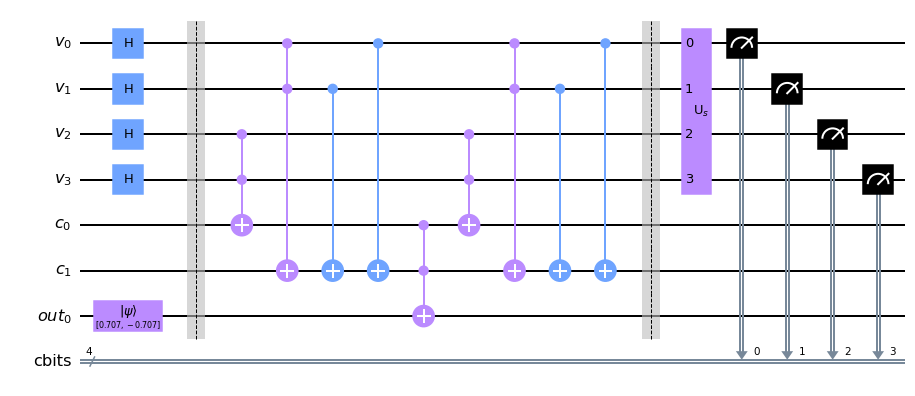

In [54]:
var_qubits = QuantumRegister(numQbits, name='v')
clause_qubits = QuantumRegister(numClauses, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(numQbits, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

## First Iteration
# Apply our oracle
univ_oracle(qc, clause_list, clause_qubits, numQbits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(numQbits), list(range(0, numQbits)))


# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw(fold=-1)

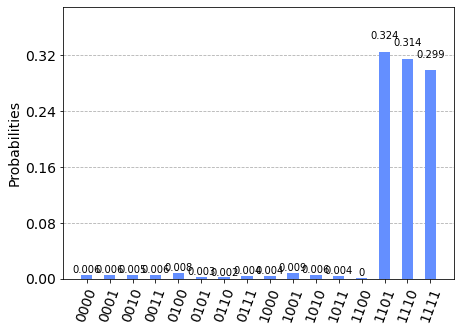

In [55]:
## Simulate and plot results
aer_sim = Aer.get_backend('aer_simulator')
aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_sim.run(qobj).result()
plot_histogram(result.get_counts())


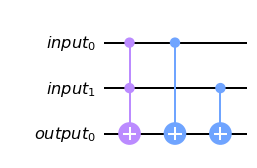

In [39]:
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
OR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw()


{'001': 42,
 '101': 31,
 '111': 32,
 '011': 790,
 '000': 38,
 '010': 30,
 '110': 28,
 '100': 33}